In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as const

from math import floor
import warnings
import struct #для распаковки .bin
import subprocess #для создания списка файлов
from numpy.fft import fft, rfft, irfft
import matplotlib as mpl
from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import Image,display

from reparse import reparse
import fourier
import data_from_input
import scipy
from source import source
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d

In [2]:
# Set the font family and size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

In [3]:
Omega = 2.35456e+15
LightVelocity = 2.99792e+10
a = 27.8508
RelativisticField = 1.33872e+08
FocalSpotWidthFWHM = 5e-4
LightVelocity = 2.99792e+10
ElectronsPerCell = 2.35165e+16/18

rep = reparse()

# Theory


In [4]:
def analytical_linear(folder_name):
    l = subprocess.check_output(['find', '.', "-name", "*_n0_*.bin"], cwd = folder_name)
    folders = l.split()
    folders.sort()
    folders = [i.decode('ascii') for i in folders]
    print(folders[:])
    n_0_list = [x[-8:-4] for x in folders]
    def change_name(old_name, variable):
        print(old_name[:-12])
        print(old_name[-9:])
        return (old_name[:-12] + variable + old_name[-10:])
    data = []
    for folderr in folders:
        folder = change_name(folderr[2:], "t")
        with open(folder_name + "/{}".format(folder), "rb") as file:
            t = np.frombuffer(file.read(), dtype = np.float32)

        folder = change_name(folderr[2:], "x")
        with open(folder_name + "/{}".format(folder), "rb") as file:
            x = np.frombuffer(file.read(), dtype = np.float32)

        folder = change_name(folderr[2:], "dxdt")
        with open(folder_name + "/{}".format(folder), "rb") as file:
            dxdt = np.frombuffer(file.read(), dtype = np.float32)

        folder = change_name(folderr[2:], "az_r")
        with open(folder_name + "/{}".format(folder), "rb") as file:
            az_r = np.frombuffer(file.read(), dtype = np.float32)

        folder = change_name(folderr[2:], "az_i")
        with open(folder_name + "/{}".format(folder), "rb") as file:
            az_i = np.frombuffer(file.read(), dtype = np.float32)

        data.append([t,x,dxdt, az_i, az_r])
    data = np.array(data, dtype=object)
    return n_0_list, data[:,0], data[:,1], data[:,2], data[:,3], data[:,4] # t, x, dxdt, no az_r, az_i

In [5]:
n_0, t_long, x_long, dxdt_long, az_i_long, az_r_long = analytical_linear("./data/theory/linear/new/long")

['./11.94/linear_long_n0_11.94.bin']
11.94/linear_long_
11.94.bin
11.94/linear_long_
11.94.bin
11.94/linear_long_
11.94.bin
11.94/linear_long_
11.94.bin
11.94/linear_long_
11.94.bin


In [6]:
n_0

['1.94']

(0.0, 150.0, -40.0, 40.0)

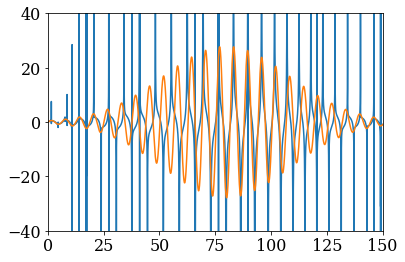

In [7]:
plt.plot(t_long[0], az_r_long[0])
plt.plot(t_long[0], az_i_long[0])
plt.axis([0,150, -40, 40])

In [8]:
fourier_i_ad, fourier_r_ad, base_ad, omega_ad, flambda_ad, fourierl_i_ad, fourierl_r_ad = fourier.fourier_of_field(az_i_long[0][1::100], az_r_long[0][1::100], 0.8, True)

# Compare

Ниже на картинках:

нижние индексы i,r различают падающие/отраженные поля;

верхние индесы t,s показывают способ получения результата (теория, моделирование);

ключевые слова steep, long различают форму падающего импульса (с резким и плавным передними фронтами соответственно), где не указано, подразумеваются импульсы с резким передним фронтом.

## Code

### Выберите параметры с помощью выпадающего списка ниже (осторожно с колёсиком)

In [9]:
def f(x):
    return x 
w = interactive(f, x=[('steep 8.70', r'./data/source/steep/energy1_n_8.70_ll_2022-02-26_11-22-52'),
                      ('steep 41.64', r'./data/source/steep/energy4_n_41.64_ll_2022-02-26_10-37-29'),
                      ('long 11.94', r'./data/source/long/energy11_n_11.94_ll_2022-02-25_14-30-02'),
                      ('long 30.30', r'./data/source/long/energy9_n_30.30_ll_2022-02-25_17-22-19')])
w

interactive(children=(Dropdown(description='x', options=(('steep 8.70', './data/source/steep/energy1_n_8.70_ll…

In [10]:
name =  w.result

idx = name.find("_", name.find("_") + 1)

n_0 = name[idx+1:-23]
print(n_0)

def reparce(files, name, field):
    bz = []
    for file in files:
        with open(name +r"/BasicOutput/data/" + field + "/" + file, mode = "rb") as f:
            line_of_data = np.frombuffer(f.read(), dtype = np.float32)
            #by_field_2_i = np.reshape(line_of_data, shape_2dfield)/RelativisticField
            bz.append(line_of_data/RelativisticField)
    return bz

l = subprocess.check_output(['ls',], cwd = name+ r'/BasicOutput/data/by2dxy')
files = l.split()
files = [i.decode('ascii') for i in files]
#print(files)

bz_i = np.array(reparce(files[100:101], name, "bz2dxy")).T[:,0]
bz_r = np.array(reparce(files[550:551], name, "bz2dxy")).T[:,0]
by_i = np.array(reparce(files[100:101], name, "by2dxy")).T[:,0]
by_r = np.array(reparce(files[550:551], name, "by2dxy")).T[:,0]

fourier_w_base_z, fourier_w_addon_z, fmax_z, omega_z, flambda_z, fourier_l_base_z, fourier_l_addon_z = fourier.fourier_of_field(bz_i, bz_r, 0.8, True)
fourier_w_base_y, fourier_w_addon_y, fmax_y, omega_y, flambda_y, fourier_l_base_y, fourier_l_addon_y = fourier.fourier_of_field(by_i, by_r, 0.8, True)

8.70


In [11]:
range1 = (3,20)
def filter_gauss(w, shift, sigma):
    return np.exp(-((w-shift)/sigma)**2/2)
# привязка пространственных частот через известное падающее поле
rfft_i = abs(np.fft.rfft(bz_i))
argmax = np.unravel_index(np.argmax(rfft_i, axis = None), rfft_i.shape)[0]


k_x = np.arange(1,np.shape(rfft_i)[0])/argmax
lambda_i = 0.8/k_x
filter_range = np.where((lambda_i<range1[1]) & (lambda_i>range1[0]),1,0)
#print(lambda_i[argmax])

#filter_shape = filter_gauss(np.arange(len(rfft_i)), sum(filter_range)/2, (filter_range[1] - filter_range[0])/2)

filtered_fft_r = (np.fft.rfft(bz_r))[1:]*filter_range[:]

filtered_r = np.fft.irfft(filtered_fft_r)

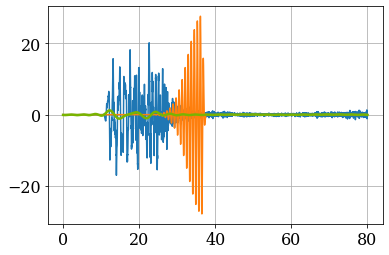

In [12]:
plt.plot(np.linspace(0,80,len(bz_r)),bz_r)
plt.plot(np.linspace(0,80,len(bz_r)),bz_i)
plt.plot(np.linspace(0,80,len(filtered_r)),filtered_r, linewidth = 2.5, color=(121/255, 180/255, 0), label = "|B|")
plt.grid()
#plt.axis([5, 40,-1.0,1.0])

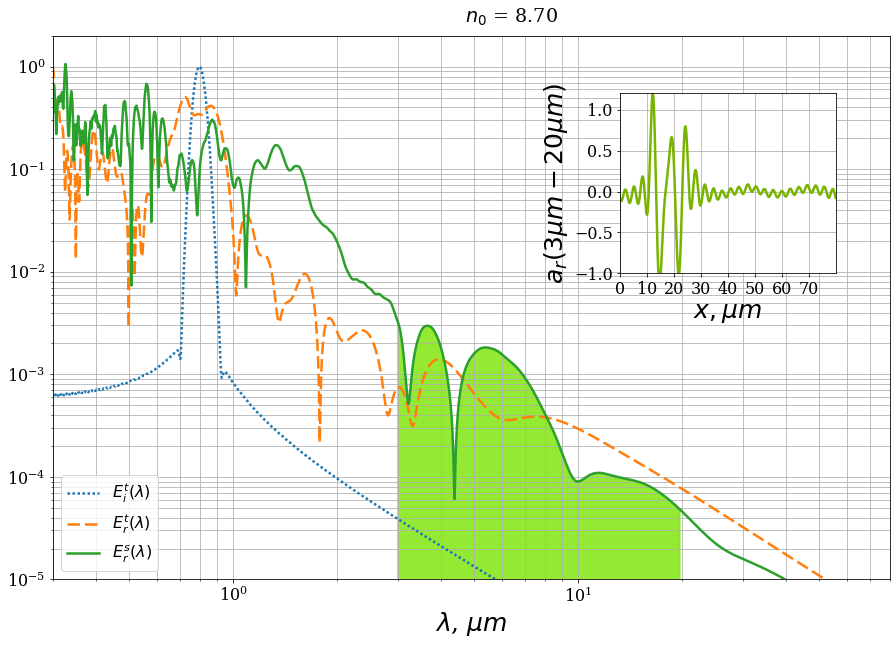

In [13]:
fig = plt.figure(figsize = (15,10))

filter_range_ii = np.where((flambda_z<range1[1]) & (flambda_z>range1[0]),1,0)

ax1 = plt.axes()  # standard axes
plt.xlabel(r"$\lambda$, $\mu m$", fontsize=25)
plt.fill_between(flambda_z ,abs(fourier_l_addon_z)*filter_range_ii, 1e-8, color=(121/255, 228/255, 0, 0.8))
ax2 = plt.axes([0.65, 0.55, 0.20, 0.25])

plt.suptitle(r"$n_0$ = {}".format(n_0), y = 0.92, x = 0.55)

ax1.loglog(flambda_ad[:] , abs(fourierl_i_ad[:]), linewidth = 2.5, label = r'$E^t_{i}(\lambda)$', linestyle = (0,(1,1)))
ax1.loglog(flambda_ad[:] , abs(fourierl_r_ad[:]), linewidth = 2.5, label = r'$E^t_{r}(\lambda)$', linestyle = (0,(5,2)))
#ax1.loglog(flambda_z[:] , rfft_i[1:]/flambda_z**2, linewidth = 2.5, label = r'$E^t_{r}(\lambda)$', linestyle = (0,(5,2)))
#ax1.loglog(flambda_sim[:] , abs(fourierl_i_sim[:]), linewidth = 2.5, label = r'$E^s_{i}(\lambda)$')
ax1.loglog(flambda_z, abs(fourier_l_addon_z), linewidth = 2.5, label = r'$E^s_{r}(\lambda)$')
ax1.legend(loc = "lower left")
ax1.axis((3e-1,8e+1,1e-5,2))
ax2.plot(np.linspace(0,80,len(filtered_r)),filtered_r, linewidth = 2.5, color=(121/255, 180/255, 0), label = "|B|")
ax2.set_xticks(np.arange(0,80,10))
ax2.set_yticks(np.arange(-4,5,0.5))
ax2.axis([-0, 80,-1.0,1.2])
plt.xlabel(r"$x, \mu m$", fontsize=25)
plt.ylabel(r"$a_r({}\mu m-{}\mu m)$".format(range1[0], range1[1]), fontsize=25)
ax1.grid(True, which="both")
ax2.grid(True, which="both")
plt.show()

# Energy

## Code

In [18]:
n_0_dop = [42.72, 21.12, 16.8, 13.02, 9.24, 7.62, 5.612, 3.767, 0.986]
doppler = [0.8371377363392384, 1.1203484753114145, 1.3026466582163776, 1.4863926442961075, 1.7863808732092692, 2.0815959098699572, 2.551373140588447,3.3187664270440136,6.046263978611545]

In [5]:
def built_graph(dl, range_l, range_n0, ulimit_e, llimit_e, dl_graph, b_doppler):
    max_l = range_l[1]+1
    min_l = range_l[0]
    num_ll = int((max_l-min_l)/dl)
    lambda_new = np.arange(min_l, max_l, dl)
    en_data = np.zeros((num_n,len(lambda_new)))
    for i in np.arange(0, num_n):
        f = interp1d(lambda_s[:,i],new_en[:,i],kind = "nearest-up")
        en_data[i,:] = f(lambda_new)
    max_n = n_0[0,num_n-1]
    min_n = n_0[0,0]
    dn = 1.5
    n_new = np.arange(min_n, max_n, dn)
    en_2D = np.zeros((len(n_new), len(lambda_new)))
    for i in np.arange(0, len(lambda_new)):
        f = interp1d(n_0[0,:],en_data[:,i],kind = "slinear")
        en_2D[:,i] = f(n_new)
    fig = plt.figure(figsize=(20,10))
    c_ax = plt.imshow(en_2D, extent = (min_l,max_l,n_0[0,num_n-1]+0.5,n_0[0,0]), aspect = "auto",  interpolation='bicubic',norm=LogNorm(vmin=llimit_e, vmax=ulimit_e))
    plt.xticks(np.arange(min_l,max_l,dl_graph))
    plt.xlabel(r"$\lambda ,$ $\mu m$")
    plt.yticks(np.arange(1,n_0[0,num_n-1],2))
    plt.ylabel(r"$n_0$")
    cbar = plt.colorbar()
    cbar.set_label("Energy, arb.u.")
    #plt.axis([range_l[0],range_l[1],range_n0[1],range_n0[0]])
    plt.title(r"a_i = {}".format(a_i))
    if b_doppler:
        plt.plot(doppler, n_0_dop, c = "r", marker = ".", markersize = 8, label = r"Doppler with $\beta$ from 1D sumulation")
        plt.legend(loc = "best")
    plt.grid()
    plt.show()

In [6]:
def energy_spec(folder_name):
    """
    Full reparse of data, given name of the folder
    ###########
    Arguments
    folder_name - str, name of folder with data files 'n0_(concentration).bin'
    ###########
    Output
    Spectrum
    
    """
    n_0, lambda_s, energy, num_n = rep.energy(folder_name, "n0*.bin")
    for i in range(len(n_0)):
        lambda_s[i] = [x for _,x in sorted(zip(n_0[i],lambda_s[i]))]
        energy[i] = [x for _,x in sorted(zip(n_0[i],energy[i]))]
        n_0[i].sort()
    
    range1 = (3,20)
    return n_0, lambda_s, energy, num_n

In [7]:
def amp_to_en(amp):
    return (a/amp)**2

In [8]:
def built_graph_compare(r1, r2, limit):
    range4 = np.zeros(num_n)
    range5 = np.zeros(num_n)
    """for i in np.arange(0, num_n_circular_steep):
        mask1 = np.where((lambda_s_circular_steep.T[i] > r1[0]) & (lambda_s_circular_steep.T[i] < r1[1]))[0]
        for i1 in mask1:
            range1[i] += energy_circular_steep[i1,i]/11*100
    for i in np.arange(0, num_n_circular_long):
        mask1 = np.where((lambda_s_circular_long.T[i] > r1[0]) & (lambda_s_circular_long.T[i] < r1[1]))[0]
        for i1 in mask1:
            range2[i] += energy_circular_long[i1,i]/20*100"""
    #for i in np.arange(0, num_n_linear_steep):
    #    mask1 = np.where((lambda_s_linear_steep.T[i] > r1[0]) & (lambda_s_linear_steep.T[i] < r1[1]))[0]
    #    for i1 in mask1:
    #        range3[i] += energy_linear_steep[i1,i]/5.5*100
    energy_i = 10/amp_to_en(a_i) #1.94, 7.71, 75, 850 - 20, 10, 3, 1
    for i in np.arange(0, num_n):
        mask1 = np.where((lambda_s.T[i] > r1[0]) & (lambda_s.T[i] < r1[1]))[0]
        for i1 in mask1:
            range4[i] += energy[i1,i]/energy_i
            
    for i in np.arange(0, num_n):
        mask1 = np.where((lambda_s.T[i] > r2[0]) & (lambda_s.T[i] < r2[1]))[0]
        for i1 in mask1:
            range5[i] += energy[i1,i]/energy_i
    fig = plt.figure(figsize=(15,10))
    plt.plot(n_0[1],range4, label = r"Low freq".format(r1[0], r1[1]), linestyle = "none", marker = ".", markersize = 12)
    plt.plot(n_0[1],range5, label = r"High freq".format(r1[0], r1[1]), linestyle = "none", marker = ".", markersize = 12)
    plt.xlabel(r"$n_0$")
    plt.ylabel(r"$\eta$ ({} - {} $\mu m$), %".format(r1[0], r1[1]))
    plt.xticks((np.arange(-1,60,2)))
    plt.yscale('log')
    #plt.yticks(np.arange(0,limit, 0.2))
    plt.ylim(1e-7, limit)
    plt.xlim(0.1, 60)
    plt.grid()
    #fig.savefig(r"./data/energy/eff_n_a_{:.02f}.png".format(a_i), format = "png")
    plt.legend()

## Result

### Change the name of the folder to view different $a_0$ (1, 3, 10, 20, 30, 30_ions)

In [9]:
name = r"./data/energy/long_a30"
n_0, lambda_s, energy, num_n = energy_spec(name)
new_en = energy[:]/lambda_s[:]**2
if name[-4:] =="ions" or name[-2:] =="30":
    a_i = a
else:
    a_i = float(name[20:])

['./n0_19.50.bin', './n0_56.76.bin', './n0_37.32.bin', './n0_3.322.bin', './n0_46.50.bin', './n0_36.24.bin', './n0_23.82.bin', './n0_7.62.bin', './n0_58.38.bin', './n0_31.92.bin', './n0_8.16.bin', './n0_44.34.bin', './n0_30.84.bin', './n0_0.353.bin', './n0_0.280.bin', './n0_36.78.bin', './n0_5.612.bin', './n0_6.00.bin', './n0_15.18.bin', './n0_37.86.bin', './n0_18.96.bin', './n0_49.74.bin', './n0_27.60.bin', './n0_16.80.bin', './n0_4.040.bin', './n0_14.64.bin', './n0_52.98.bin', './n0_54.06.bin', './n0_1.407.bin', './n0_54.60.bin', './n0_51.36.bin', './n0_42.72.bin', './n0_33.00.bin', './n0_40.02.bin', './n0_13.56.bin', './n0_14.10.bin', './n0_39.48.bin', './n0_23.28.bin', './n0_35.70.bin', './n0_59.46.bin', './n0_50.28.bin', './n0_50.82.bin', './n0_31.38.bin', './n0_0.379.bin', './n0_4.692.bin', './n0_7.08.bin', './n0_24.36.bin', './n0_21.12.bin', './n0_9.24.bin', './n0_34.08.bin', './n0_12.48.bin', './n0_32.46.bin', './n0_55.14.bin', './n0_53.52.bin', './n0_0.520.bin', './n0_38.94.bi

In [19]:
interactive_plot = interactive(built_graph,
                        dl = widgets.FloatText(value= 0.05),
                        range_l = widgets.FloatRangeSlider(min=0,max=20,step=0.1,value= [0.5, 10.0]),
                        range_n0 = widgets.FloatRangeSlider(min=n_0[0,0],max=99,step=1,value= [n_0[0,0], 59]),
                        ulimit_e = widgets.FloatText(value= 2e-1),
                        llimit_e = widgets.FloatText(value= 6e-7),
                        dl_graph = widgets.FloatText(value= 0.5),
                        b_doppler = widgets.Checkbox(True, description='Do you need Doppler curve?'))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

interactive(children=(FloatText(value=0.05, description='dl'), FloatRangeSlider(value=(0.5, 10.0), description…

In [11]:
interactive_plot = interactive(built_graph_compare,
                            r1 = widgets.FloatRangeSlider(min=0.02,max=50,step=0.1,value= [3.02, 49.1]),
                            r2 = widgets.FloatRangeSlider(min=0.02,max=50,step=0.1,value= [0.02, 0.1]),
                            limit = widgets.FloatText(value= 0.1))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

interactive(children=(FloatRangeSlider(value=(3.02, 49.1), description='r1', max=50.0, min=0.02), FloatRangeSl…

# 2D

In [4]:
import gzip
from scipy import ndimage

Omega = 2.35456e+15
LightVelocity = 2.99792e+10
a = 33.4522
RelativisticField = 1.33872e+08

ElectronsPerCell_2D = 6.96784e+10
n0 = 40.0

#name = r"/media/nikita/Test/midIR/2D/first_p_2D/ez2dxy/"
name = r"./data/2D/2D_defect_n40/ez2dxy/"
name = r"/media/nikita/Test/midIR/2D/first_p_2D/2D/defect_n40_big_2022-10-05_12-31-41/BasicOutput/data/ez2dxy/"
l = subprocess.check_output(['ls',], cwd = name)
files = l.split()
files = [i.decode('ascii') for i in files]
print(files)
shape_2dfield = (3000, 7000)

['000000.gz', '000100.gz', '000200.gz', '000300.gz', '000400.gz', '000500.gz', '000600.gz', '000700.gz', '000800.gz', '000900.gz', '001000.gz', '001100.gz', '001200.gz', '001300.gz', '001400.gz', '001500.gz', '001600.gz', '001700.gz', '001800.gz', '001900.gz', '002000.gz', '002100.gz', '002200.gz', '002300.gz', '002400.gz', '002500.gz', '002600.gz']


In [5]:
len(files)

i = 0 # надо указать момент времени, когда полностью виден падающий импульс (100-180)
i = 6
for file in files[i:i+1]:
    #by_field_2_i = np.zeros((1200,1200))# массив по времени массивов по азимутальному углу амплитуды поля 
    with gzip.open(name + file, mode = "rb") as f:
        line_of_data = np.frombuffer(f.read(), dtype = np.float32)
        by_field_2_i = np.reshape(line_of_data, shape_2dfield)/RelativisticField

i = 1 # надо указать момент времени, когда полностью виден отражённый импульс (300+)
i = 10
for file in files[i:i+1]:
    with gzip.open(r"/media/nikita/Test/midIR/2D/first_p_2D/2D/defect_n40_big_2022-10-05_12-31-41/BasicOutput/data/electron2dxy/"+ file, mode = "rb") as f:
        line_of_data = np.frombuffer(f.read(), dtype = np.float32)
        ne_2_p = np.reshape(line_of_data, shape_2dfield)/ElectronsPerCell_2D*n0/4
    """with gzip.open(r"./data/2D/2D_defect_n40/electron2dxy/"+ file, mode = "rb") as f:
        line_of_data = np.frombuffer(f.read(), dtype = np.float32)
        ne_2_p = np.reshape(line_of_data, shape_2dfield)/ElectronsPerCell_2D*n0/4"""
    
for file in files[i:i+1]:
    #by_field_2_i = np.zeros((1200,1200))# массив по времени массивов по азимутальному углу амплитуды поля 
    with gzip.open(name+ file, mode = "rb") as f:
        line_of_data = np.frombuffer(f.read(), dtype = np.float32)
        by_field_2_p = np.reshape(line_of_data, shape_2dfield)/RelativisticField
#by_field_2_r[:,1200:] = 0
i = 2 # надо указать момент времени, когда полностью виден отражённый импульс (300+)
i = 17
for file in files[i:i+1]:
    #by_field_2_i = np.zeros((1200,1200))# массив по времени массивов по азимутальному углу амплитуды поля 
    with gzip.open(name+ file, mode = "rb") as f:
        line_of_data = np.frombuffer(f.read(), dtype = np.float32)
        by_field_2_r = np.reshape(line_of_data, shape_2dfield)/RelativisticField

In [6]:
import functools

import scipy.fft as fft

def _get_ND_butterworth_filter(shape, factor, order, high_pass, real,
                               dtype=np.float64):
    ranges = []
    for i, d in enumerate(shape):
        # start and stop ensures center of mask aligns with center of FFT
        axis = np.arange(-(d - 1) // 2, (d - 1) // 2 + 1) / (d * factor)
        ranges.append(fft.ifftshift(axis ** 2))
    # for real image FFT, halve the last axis
    if real:
        limit = d // 2 + 1
        ranges[-1] = ranges[-1][:limit]
    # q2 = squared Euclidian distance grid
    q2 = functools.reduce(
            np.add, np.meshgrid(*ranges, indexing="ij", sparse=True)
            )
    q2 = q2.astype(dtype)
    wfilt = 1 / (1 + np.power(q2, order))
    if high_pass:
        wfilt = 1 - wfilt
    return wfilt


def butterworth(
    image,
    cutoff_frequency_ratio=0.005,
    high_pass=True,
    order=2.0,
    channel_axis=None,
):
    fft_shape = (image.shape if channel_axis is None
                 else np.delete(image.shape, channel_axis))
    is_real = np.isrealobj(image)
    float_dtype = image.dtype
    wfilt = _get_ND_butterworth_filter(
        fft_shape, cutoff_frequency_ratio, order, high_pass, is_real,
        float_dtype
    )
    axes = np.arange(image.ndim)
    if channel_axis is not None:
        axes = np.delete(axes, channel_axis)
        abs_channel = channel_axis % image.ndim
        post = image.ndim - abs_channel - 1
        sl = ((slice(None),) * abs_channel + (np.newaxis,) +
              (slice(None),) * post)
        wfilt = wfilt[sl]
    if is_real:
        butterfilt = fft.irfftn(wfilt * fft.rfftn(image, axes=axes),
                                s=fft_shape, axes=axes)
    else:
        butterfilt = fft.ifftn(wfilt * fft.fftn(image, axes=axes),
                               s=fft_shape, axes=axes)
    return butterfilt

In [46]:
MatrixSize_X = 7000
MatrixSize_Y = 3000
X_Min = -120.0e-4
X_Max =  20.0e-4
Y_Min = -30.0e-4
Y_Max =  30.0e-4

Wavelength = 0.8e-4

fs = MatrixSize_X/((X_Max-X_Min)/Wavelength) # number of samples per wavelength

# filter low frequencies for wl > wl_low and wl < wl_high
wl_low = 3e-4
filtered_r_l = butterworth(by_field_2_r, cutoff_frequency_ratio=Wavelength/wl_low/fs, high_pass=False, order=5)
#filtered_r_l = butterworth(by_field_2_r, cutoff_frequency_ratio=wl_low/Wavelength/fs, high_pass=False, order=5)
filtered_r_l[np.abs(filtered_r_l) > 0.05] = 0 # rough filtering of plasma and boundary fields, should be done by masking those areas

# filter high frequencies for wl_high/4 < wl < wl_high
wl_high = 0.3e-4
filtered_r_h = butterworth(by_field_2_r, cutoff_frequency_ratio=Wavelength/(wl_high/4)/fs, high_pass=False, order=5)
filtered_r_h = butterworth(filtered_r_h, cutoff_frequency_ratio=Wavelength/wl_high/fs, high_pass=True, order=5)
filtered_r_h[np.where(np.abs(filtered_r_h) < 1.)] = 0 # to suppress noise

#mask_bl = np.where(abs(filtered_r_l) > 4.1e-3, 0.95, 0.001)
mask_bl = np.where(abs(filtered_r_l) > 4e-3, 1.0, 0)
mask_bh = np.where(abs(filtered_r_h) > 4e-1, 0.99, 0.001)
mask_bi = np.where(abs(by_field_2_i) > 5e-1, 0.99, 0.001)

mask_ne = np.where(ne_2_p > 1e-3, 0.99, 0.01)

x = np.linspace(-120,20, ne_2_p.shape[1])
y = -np.linspace(-30,30, ne_2_p.shape[0])

x_axis, y_axis = np.meshgrid(x, y)

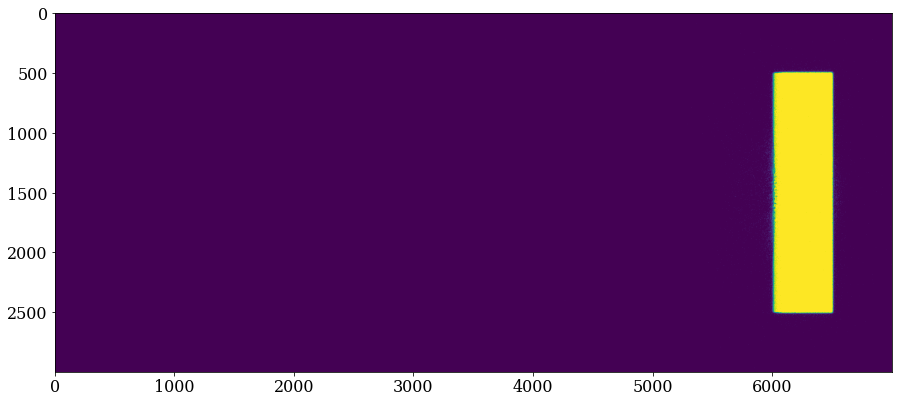

In [47]:
fig = plt.figure(figsize=(15,10))
plt.imshow(mask_ne)

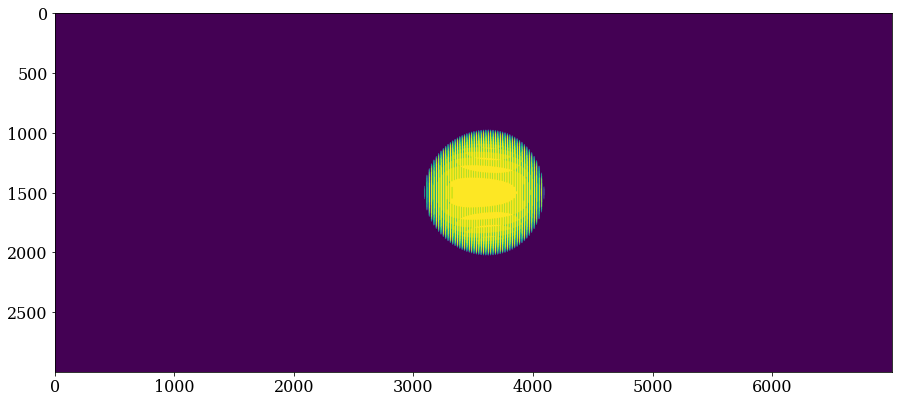

In [48]:
fig = plt.figure(figsize=(15,10))
plt.imshow(mask_bi)

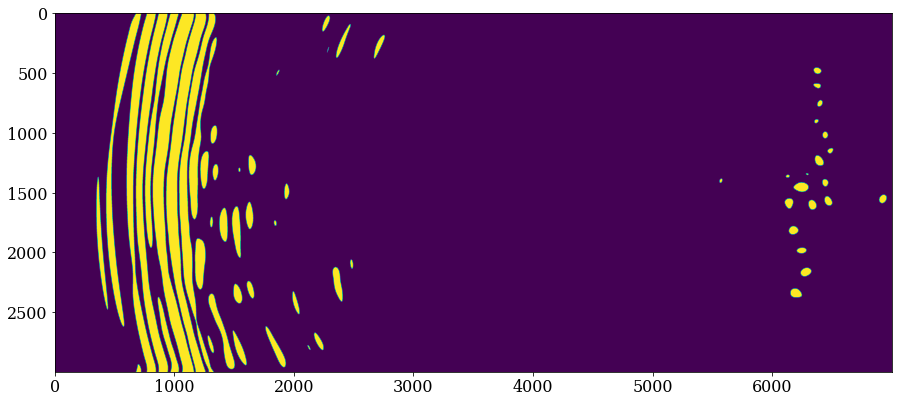

In [49]:
fig = plt.figure(figsize=(15,10))
plt.imshow(mask_bl)

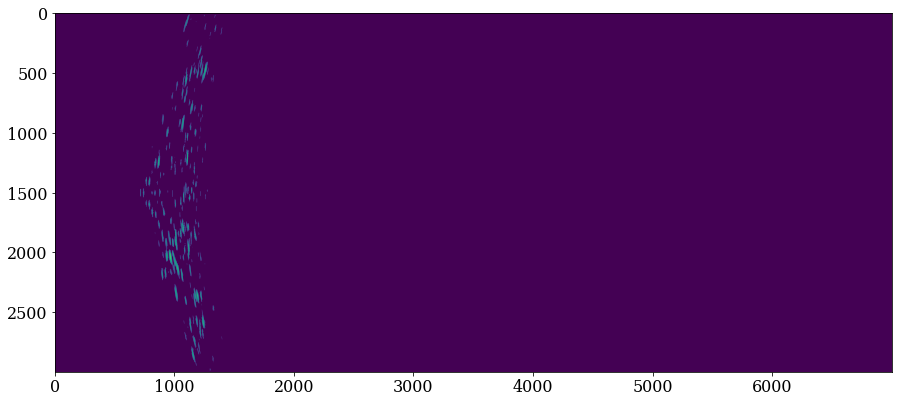

In [50]:
fig = plt.figure(figsize=(15,10))
plt.imshow(mask_bh)

In [51]:
mask_b = np.where(x_axis > -90, 0.00, 1.0)

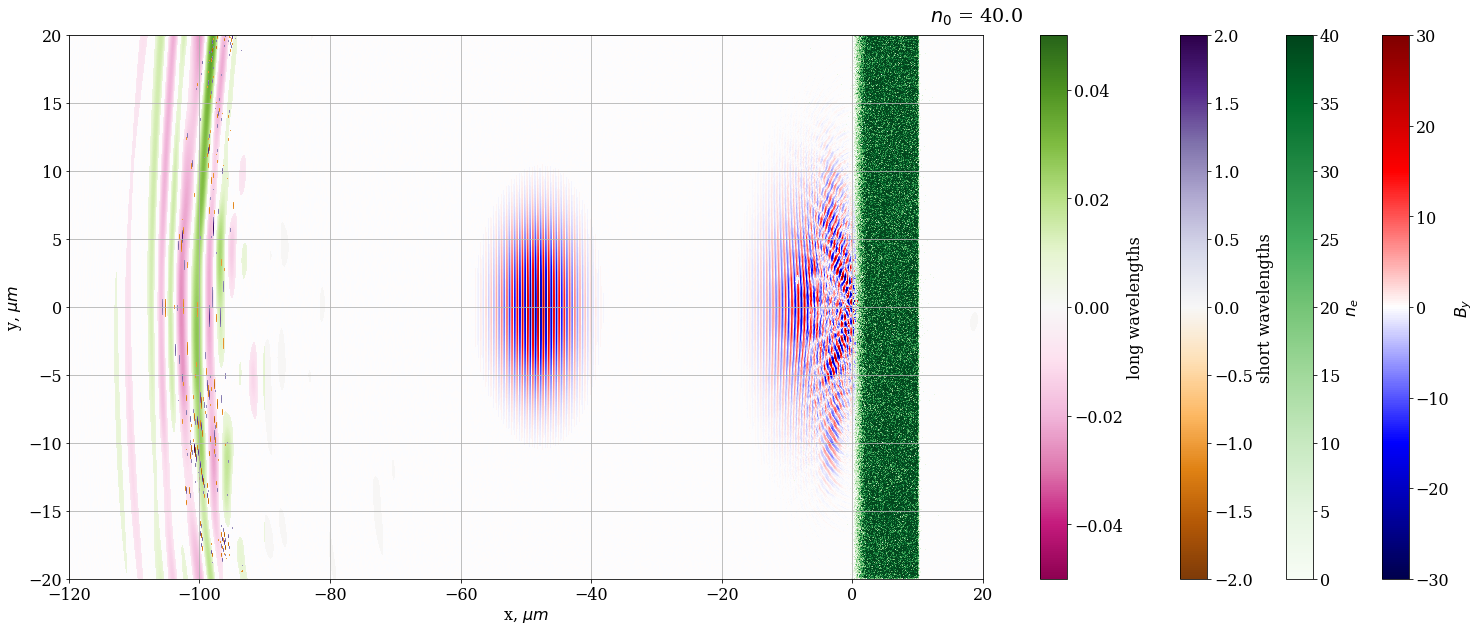

In [55]:
fig = plt.figure(figsize=(40,10))
plt.suptitle(r"$n_0$ = 40.0", y = 0.92, x = 0.44)


img1 = plt.imshow(filtered_r_h, cmap='PuOr', interpolation='none', extent=[-120, 20,-30, 30], aspect='auto', vmin = -2, vmax = 2)
img2 = plt.imshow(filtered_r_l*mask_b, cmap='PiYG', interpolation='none', extent=[-120, 20,-30, 30], aspect='auto', vmin = -0.05, vmax = 0.05)
img3 = plt.imshow(ne_2_p, cmap='Greens', interpolation='none',extent=[-120, 20,-30, 30], aspect='auto', vmin = 0, vmax = 40)
img4 = plt.imshow(by_field_2_i, cmap='seismic', interpolation='none',extent=[-120, 20,-30, 30], aspect='auto', vmin = -30, vmax = 30)


img5 = plt.imshow(by_field_2_p, cmap='seismic', interpolation='none',extent=[-120, 20,-30, 30], aspect='auto', vmin = -30, vmax = 30)
img7 = plt.imshow(filtered_r_l*mask_b, alpha = mask_bl, cmap='PiYG', interpolation='none', extent=[-120, 20,-30, 30], aspect='auto', vmin = -0.03, vmax = 0.03)
img6 = plt.imshow(filtered_r_h, alpha = mask_bh, cmap='PuOr', interpolation='none', extent=[-120, 20,-30, 30], aspect='auto', vmin = -2, vmax = 2)
img8 = plt.imshow(by_field_2_i, alpha = mask_bi, cmap='seismic', interpolation='none',extent=[-120, 20,-30, 30], aspect='auto', vmin = -30, vmax = 30)
img9 = plt.imshow(ne_2_p, alpha = mask_ne, cmap='Greens', interpolation='none',extent=[-120, 20,-30, 30], aspect='auto', vmin = 0, vmax = 40)

plt.colorbar(img5, label = r"$B_y$", anchor = (-1.9, 0.0))
plt.colorbar(img3, label = r"$n_e$", anchor = (-1.25, 0.0))
plt.colorbar(img1, label = "short wavelengths", anchor = (-0.55, 0.0))
plt.colorbar(img2, label = "long wavelengths", anchor = (0.0, 0.0))

plt.xlabel(r"x, $\mu m$")
plt.ylabel(r"y, $\mu m$")
plt.axis([-120,20,-20,20])
plt.grid()
#fig.savefig("/home/nikita/Documents/science/midIR/paper1/2D_n0_4.0.png", dpi=fig.dpi, format = "png")
plt.show()

In [53]:
fft_r_h = np.fft.fftshift(np.fft.fft2(filtered_r_h))
fft_r_l = np.fft.fftshift(np.fft.fft2(filtered_r_l))
fft_i = np.fft.fftshift(np.fft.fft2(by_field_2_i))

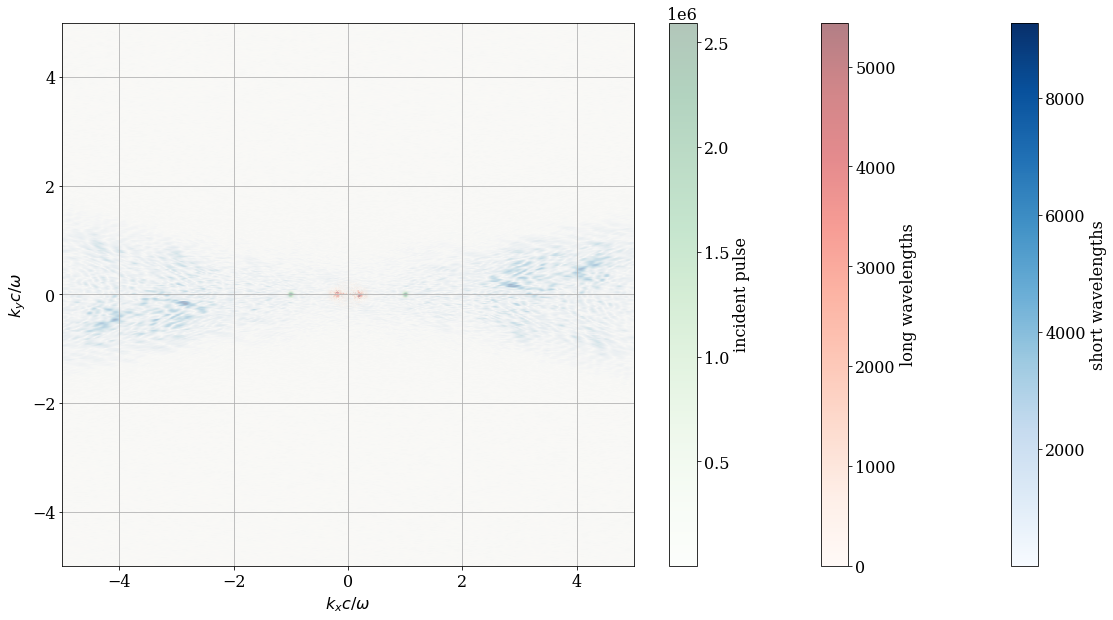

In [54]:
fig = plt.figure(figsize=(20,10))
# plt.suptitle(r"$n_0$ = 40.0", y = 0.92, x = 0.44)

img1 = plt.imshow(np.abs(fft_r_h), cmap='Blues', interpolation='none', extent=[-fs/2, fs/2, -fs/2, fs/2], aspect='auto')
img2 = plt.imshow(np.abs(fft_r_l), cmap='Reds', interpolation='none', extent=[-fs/2, fs/2, -fs/2, fs/2], aspect='auto', alpha = 0.5)
img3 = plt.imshow(np.abs(fft_i), cmap='Greens', interpolation='none', extent=[-fs/2, fs/2, -fs/2, fs/2], aspect='auto', alpha = 0.3)
plt.colorbar(img1, label = "short wavelengths")
plt.colorbar(img2, label = "long wavelengths")
plt.colorbar(img3, label = "incident pulse")

plt.xlabel(r"$k_xc/\omega$")
plt.ylabel(r"$k_yc/\omega$")
plt.axis([-5,5,-5,5])
plt.grid()
#fig.savefig("/home/nikita/Documents/science/midIR/paper1/2D_n0_4.0.png", dpi=fig.dpi, format = "png")
plt.show()